In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import cv2
import os

import networkx as nx
from skimage.morphology import skeletonize, binary_closing, remove_small_objects, square
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph

# Load masks

In [2]:
roots_dir = f"..\\Task_6\\Kaggle\\root_systems"
roots_paths = sorted(glob.glob(os.path.join(roots_dir, "*.png")))
print("Found roots:", len(roots_paths))

Found roots: 95


# Display

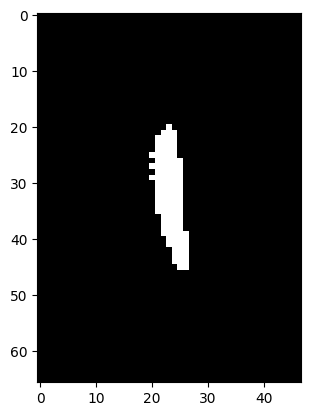

In [38]:
mask = cv2.imread(roots_paths[12], 0)
plt.imshow(mask, cmap='gray')

In [39]:
kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
root_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_vert)

In [5]:
# plt.imshow(root_closed, cmap='gray')

# Skeletonize

In [40]:
close_k = 4

binary = (root_closed > 0).astype(np.uint8)
binary = binary_closing(binary, square(close_k))
num, labels = cv2.connectedComponents(binary.astype(np.uint8))
counts = np.bincount(labels.ravel())
main_label = counts[1:].argmax() + 1
binary = labels == main_label

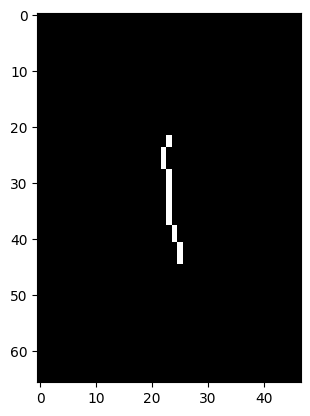

In [41]:
# binary = (mask > 0).astype(np.uint8)
skel = skeletonize(binary)

# 2) Build graph
skeleton = Skeleton(skel)
g0, c0 = skeleton_to_csgraph(skel)
plt.imshow(skeleton, cmap='gray')

<Axes: >

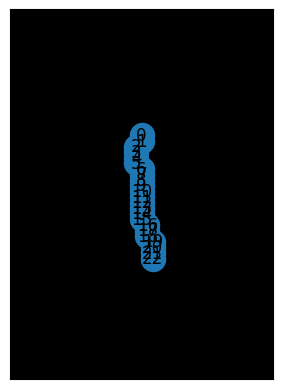

In [42]:
from skan import draw
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(g0, np.transpose(c0), image=skeleton, axis=ax)

In [43]:
branch_data = summarize(skeleton)
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,22,23.656854,0,1.0,0.0,22,23,44,25,22,23,44,25,22.090722


In [ ]:
# # This is how we can convert the output of skan to a NetworkX graph
# G = nx.from_pandas_edgelist(branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

In [ ]:
# G.nodes

NodeView((0, 22))

In [45]:
coords = np.column_stack(c0)

In [46]:
G2 = nx.from_scipy_sparse_array(g0)

# Root calculation

In [14]:
# y_by_node = {}
# for _, row in branch_data.iterrows():
#     y_by_node.setdefault(row['node-id-src'], row['coord-src-0'])
#     y_by_node.setdefault(row['node-id-dst'], row['coord-dst-0'])

In [15]:
# base = min(y_by_node, key=y_by_node.get).astype(int)

In [16]:
# base

In [48]:
# restrict to largest connected component
components = list(nx.connected_components(G2))
largest = max(components, key=len)
G2 = G2.subgraph(largest).copy()
coords_sub = coords

In [50]:
tips = [n for n, d in G2.degree() if d == 1]

In [51]:
tips

[0, 22]

In [52]:
dist_from_tip = {}
for t in tips:
    try:
        dist_from_tip[t] = nx.single_source_dijkstra_path_length(G2, t, weight='weight')
    except nx.NetworkXNoPath:
        dist_from_tip[t] = {}

In [53]:
base = min(largest, key=lambda n: (coords_sub[n, 0], coords_sub[n, 1]))

[single_source_dijkstra_path_length](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra_path_length.html)

In [54]:
dist = nx.single_source_dijkstra_path_length(G2, base, weight='weight')
far_tip = max(tips, key=lambda n: dist.get(n, -1))

In [55]:
far_tip

22

In [56]:
path_idx = np.asarray(nx.shortest_path(G2, base, far_tip, weight='weight'), dtype=int)

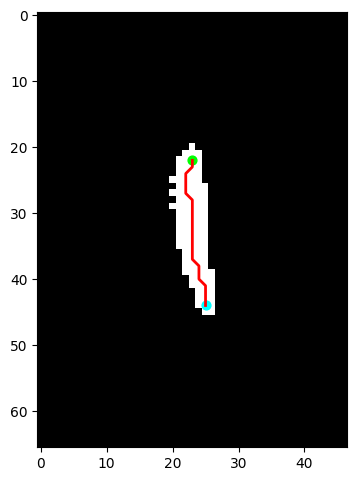

In [57]:
ys = coords[path_idx, 0]
xs = coords[path_idx, 1]

plt.figure(figsize=(4, 10))
plt.imshow(mask, cmap='gray')
plt.plot(xs, ys, 'r-', lw=2)
plt.scatter(xs[0], ys[0], c='lime', s=40)
plt.scatter(xs[-1], ys[-1], c='cyan', s=40)
plt.show()

In [29]:
# # Evaluate each tip with dijkstra_path_length, pick the farthest
# best_tip = None
# best_len = -1.0 # it ensure that eny found path will be longer
# best_path = None

# for tip in tips:
#     try:
#         path_len = nx.dijkstra_path_length(G, base, tip, weight='branch-distance')
#     except nx.NetworkXNoPath:
#         continue
#     if path_len > best_len:
#         best_len = path_len
#         best_tip = tip
#         best_path = nx.dijkstra_path(G, base, tip, weight='branch-distance')

# primary_tip = best_tip
# primary_len_px = best_len
# primary_path = best_path

In [30]:
# print('Primary tip', primary_tip, '; Lenght [px]:', primary_len_px)

In [31]:
# primary_path

In [32]:
# coords = np.column_stack(c0)            # (n_nodes, 2) y,x

# # ensure primary_path is a 1D int array
# path_idx = np.asarray(primary_path, dtype=int)

# print(path_idx[:5], path_idx.dtype, path_idx.min(), path_idx.max(), coords.shape)
# # path_idx.max() must be < coords.shape[0]

# ys = coords[path_idx, 0]
# xs = coords[path_idx, 1]

# plt.imshow(mask, cmap='gray')
# plt.plot(xs, ys, 'r-', lw=2)
# plt.scatter(xs[0], ys[0], c='lime', s=40)  # base
# plt.scatter(xs[-1], ys[-1], c='cyan', s=40)  # tip
# plt.axis('off')
# plt.show()


# Function with .csv output

In [34]:
def primary_length_px(img_path):
    mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return np.nan
    kernel_vert = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_vert)
    skel = skeletonize((mask_closed > 0).astype(np.uint8))
    g0, c0 = skeleton_to_csgraph(skel)

    coords = np.column_stack(c0)
    if coords.size == 0:
        return 0
    
    G = nx.from_scipy_sparse_array(g0)  # edges have 'weight'
    base = int(np.argmin(coords[:, 0]))           # topmost node
    tips = [n for n, d in G.degree() if d == 1]
    if not tips:
        return 0
    
    # Evaluate each tip with dijkstra_path_length, pick the farthest
    best_tip = None
    best_len = 0 # it ensure that any found path will be longer
    best_path = None

    for tip in tips:
        try:
            path_len = nx.dijkstra_path_length(G, base, tip, weight='branch-distance')
        except nx.NetworkXNoPath:
            continue
        if path_len > best_len:
            best_len = path_len
            best_tip = tip

    primary_len_px = best_len
    return primary_len_px

rows = []
for p in roots_paths:  # from your earlier cell
    plant_id = os.path.splitext(os.path.basename(p))[0]
    length_px = primary_length_px(p)
    rows.append({"Plant ID": plant_id, "Length (px)": length_px})

df = pd.DataFrame(rows)
df.to_csv("submission.csv", index=False)
df.head()


,Plant ID,Length (px)
0,test_image_01_plant_1,568
1,test_image_01_plant_2,12
2,test_image_01_plant_3,0
3,test_image_01_plant_4,29
4,test_image_01_plant_5,1429


In [35]:
def primary_length_px(img_path):
    close_k = 4

    mask = cv2.imread(img_path, 0)
    if mask is None:
        return 0
    
    # Close small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 3))
    mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Binarize, close, keep only largest blob
    binary = (mask_closed > 0).astype(np.uint8)
    binary = binary_closing(binary, square(close_k))
    num, labels = cv2.connectedComponents(binary.astype(np.uint8))
    if num <= 1:
        return 0
    
    counts = np.bincount(labels.ravel())
    main_label = counts[1:].argmax() + 1
    binary = labels == main_label

    skel = skeletonize(binary)
    g0, c0 = skeleton_to_csgraph(skel)
    coords = np.column_stack(c0)
    if coords.size == 0 or g0.shape[0] == 0:
        return 0
    
    G = nx.from_scipy_sparse_array(g0)  # edges have 'weight'
    
    components = list(nx.connected_components(G))
    largest = max(components, key=len)
    G = G.subgraph(largest).copy()

    # filter nodes to those with valid coords indices
    valid_nodes = {n for n in G.nodes if n < coords.shape[0]}
    if not valid_nodes:
        return 0
    G = G.subgraph(valid_nodes).copy()
    
    # Tips and base
    tips = [n for n, d in G.degree() if d == 1]
    if not tips:
        return 0
    
    # base = topmost node in this component
    base = min(largest, key=lambda n: (coords[n, 0], coords[n, 1]))
    
    dist = nx.single_source_dijkstra_path_length(G, base, weight='weight')
    best_len = -1.0
    best_tip = None
    for tip in tips:
        L = dist.get(tip, -1)
        if L > best_len:
            best_len = L
            best_tip = tip

    if best_tip is None:
        return 0
    else:
        return best_len

rows = []
for p in roots_paths:  # from your earlier cell
    plant_id = os.path.splitext(os.path.basename(p))[0]
    length_px = primary_length_px(p)
    rows.append({"Plant ID": plant_id, "Length (px)": length_px})

df = pd.DataFrame(rows)
df.to_csv("submission.csv", index=False)
df.head()


,Plant ID,Length (px)
0,test_image_01_plant_1,641.658946
1,test_image_01_plant_2,1149.452886
2,test_image_01_plant_3,0.000000
3,test_image_01_plant_4,1285.298557
4,test_image_01_plant_5,1570.832611
